Export of minimal data from spatial transcriptomics - VISIUM v1
==

This notebook is used to export data from VISIUM v1 data sets produced by SpaceRanger. 

_Requirements:_
- `scverse`
- `scikit-image`
- `matplotlib`
- `pandas`
- `shapely`

_**WARNING**_

Sometimes, the spot coordinates are not given in the high-resolution image normal coordinate system. Pay attention to
the image and save the export data only if the image is correct! Otherwise, adjust the (x,y) coordinates of the spots (e.g, apply a rotation, etc)

In [1]:
import spatialdata_io as spio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import json
from skimage.draw import disk
from skimage.io import imsave
from pathlib import Path

/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


The following cell defines the parameters of the notebook (you can use it for Papermill):

In [2]:
SID = "SN124_A798015_Rep2"                      # sample ID
pth = Path("/home/vlad/Projects/SpTx/data/visium_crc_cms/SN124/")      # path to the root of the dataset (same name as the SID)
dst = Path("/home/vlad/Projects/SpTx/visium/")                         # where to create the folder `SID` with resulting data files

Read the spatial dataset:

In [3]:
sd = spio.visium(
    pth / SID,
    dataset_id = SID,
)

INFO     reading                                                                                                   
         /home/vlad/Projects/SpTx/data/visium_crc_cms/SN124/SN124_A798015_Rep2/filtered_feature_bc_matrix.h5       


/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/spatialdata/models/models.py:1144: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


In [38]:
# Get the essential data from the dataset:
himg = np.array(sd.images[SID+'_hires_image'])   # high resolution image (is supposed to be the space in which the spots exist)
himg = np.permute_dims(himg, [1,2,0])            # get the axes (row, col, channel)
h, w = himg.shape[0:2]

gex = pd.DataFrame(sd.tables['table'].X.todense())  # gene expression
gex.columns = sd.tables['table'].var.index
gex.index = sd.tables['table'].obs.index

g_annot = sd.tables['table'].var                    # gene annotations

sf = 1.0                                            # scale factor for hires img coords 
with open(pth / SID  / "spatial/scalefactors_json.json", 'r') as sf:
        sf = json.load(sf)['tissue_hires_scalef']

r = [sf * r for r in sd.shapes[SID].radius]
z = np.array([shapely.get_coordinates(p)[0].tolist() for p in sd.shapes[SID].geometry])
x, y = sf * z[:,0], sf * z[:,1]

# # use this when the spot coords are rotated 90 deg CW:
# x -= w / 2
# y -= h / 2
# yp  = -x
# xp  = y
# x = xp + w / 2
# y = yp + h / 2
# # end rotation

spots = pd.DataFrame({'x': x, 'y': y, 'radius': r, 'spot_id': sd.tables['table'].obs.spot_id}) # spots (x,y) and radius
spots.index = sd.tables['table'].obs.index

In [39]:
spots.head()

,x,y,radius,spot_id
AAACAGAGCGACTCCT-1,1365.544174,476.329919,8.154962,0
AAACCGGGTAGGTACC-1,536.847245,1085.407521,8.154962,1
AAACCGTTCGTCCAGG-1,711.566621,1304.050762,8.154962,2
AAACCTCATGAAGTTG-1,423.621281,976.085900,8.154962,3
AAACGAGACGGTTGAT-1,1176.183509,934.114206,8.154962,4


In [40]:
gex.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGGGTAGGTACC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTTCGTCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTCATGAAGTTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAGACGGTTGAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Verify** whether the spots are falling in the right positions. If not, you might need to transpose the image.

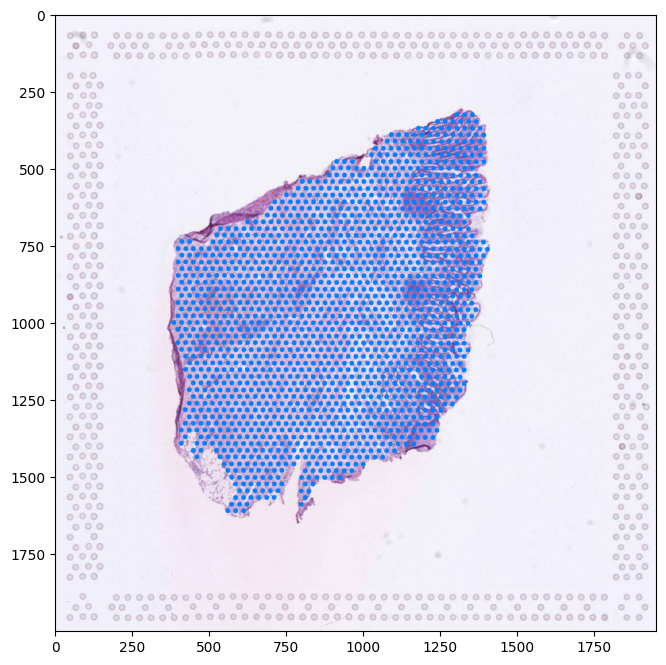

In [41]:
s_img = himg.copy()  # for show()
for i in range(spots.shape[0]):
    x, y, rd = spots[["x", "y", "radius"]].iloc[i]
    r, c = disk( (int(y), int(x)), # (row, col)
                int(rd), shape=s_img.shape )
    s_img[r, c] = (0, 128, 255)

plt.subplots(figsize=(8,8))
plt.imshow(s_img)

Save the data
---

If all looks good, save the data:
- gene expression matrix to `expression.feather`,
- gene annotation data to `genes.feather`,
- spots positions to `spots.feather`, and
- image to `hires_image.png`

In [42]:
if not (dst / SID).exists():
    (dst / SID).mkdir(parents=True)
    
gex.to_feather(dst / SID / "expression.feather", compression_level=9)
g_annot.to_feather(dst / SID / "genes.feather", compression_level=9)
spots.to_feather(dst / SID / "spots.feather", compression_level=9)
imsave(dst / SID / "hires_image.png", himg)

In [36]:
spots.shape

(1656, 4)

In [37]:
gex.shape

(1656, 36601)